# ОИАД. Лабораторная работа №2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import math
from scipy.linalg import solve
import warnings
warnings.filterwarnings('ignore')

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) $N \\% 5$
2) $N^2 \\% 5 + 5$
где $N$ - номер в списке

То есть столбец 1 - mass  
столбец 2 - pages


In [2]:
df = pd.read_csv('students_simple.csv')
X = df['mass'].values
Y = df['pages'].values

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [3]:
def Fechner(X, Y):
    assert len(X) == len(Y), 'X and Y must have the same size'
    n = len(X)
    K = np.sum(np.count_nonzero(np.sign(X-np.mean(X)) == np.sign(Y-np.mean(Y))) - np.count_nonzero(np.sign(X-np.mean(X)) != np.sign(Y-np.mean(Y)))) / n
    return K

In [4]:
print(Fechner(X, Y))

0.3


In [5]:
def Pierson(X, Y, conf=0.95):
    assert len(X) == len(Y), 'X and Y must have the same size'
    n = len(X)
    cov = np.sum((X-np.mean(X))*(Y-np.mean(Y))) / (n-1)
    
    Sx_sq = np.sum(X-np.mean(X) ** 2) / (n-1)
    Sy_sq = np.sum(Y-np.mean(Y) ** 2) / (n-1)

    K = cov / np.sqrt(Sx_sq*Sy_sq)

    z_value = 0.5 * np.log((1 + K) / (1 - K))
    z_cr = stats.norm.ppf((1 + conf) / 2)

    z_low, z_high = z_value - z_cr * (1 / np.sqrt(n - 3)), z_value + z_cr * (1 / np.sqrt(n - 3))
    r_low, r_high = (np.exp(2*z_low) - 1) / (np.exp(2*z_low) + 1), (np.exp(2*z_high) - 1) / (np.exp(2*z_high) + 1)
    
    return K, r_low, r_high

In [6]:
print(Pierson(X, Y))

(np.float64(0.02637389047312111), np.float64(-0.4210610934432964), np.float64(0.46348533773198003))


In [7]:
def Spearman(X, Y):
    assert len(X) == len(Y), 'X and Y must have the same size'
    n = len(X)
    X_sorted = sorted(X)
    Y_sorted = sorted(Y)

    val_to_rank_X = {val: np.mean([i+1 for i, x in enumerate(X_sorted) if x == val]) for val in list(set(X))}
    val_to_rank_Y = {val: np.mean([i+1 for i, y in enumerate(Y_sorted) if y == val]) for val in list(set(Y))}

    R_x = [val_to_rank_X[x] for x in X]
    R_y = [val_to_rank_Y[y] for y in Y]

    K, _, _ = Pierson(R_x, R_y)
    return K

In [9]:
print(Spearman(X, Y))

0.11115288220551378


In [8]:
def Candell(X, Y):
    assert len(X) == len(Y), 'X and Y must have the same size'
    n = len(X)
    S = np.sum([int(int(X[i] < X[j]) != int(Y[i] < Y[j])) for i in range(n-1) for j in range(i+1, n)])
    K = 1 - (4 / (n*(n-1)))*S
    return K

In [9]:
print(Candell(X, Y))

0.13684210526315788


### Выводы
Таким образом, коэффициенты корреляции близки к нулю, что говорит о малой связи между переменными

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

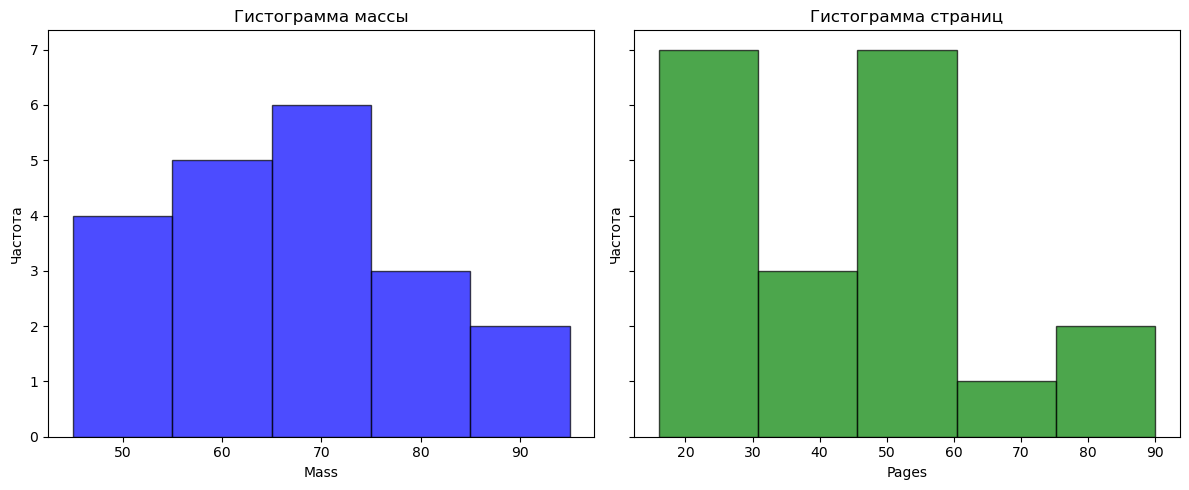

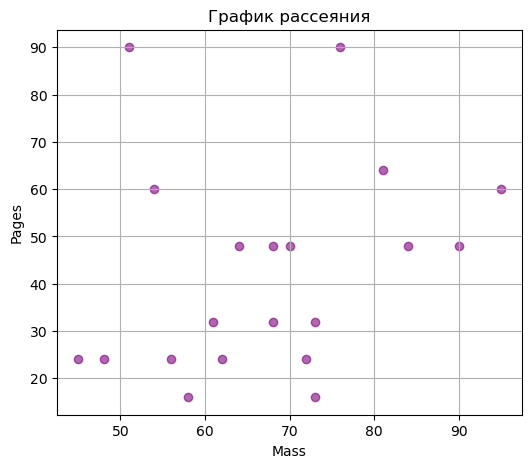

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].hist(X, bins=5, alpha=0.7, color='blue', edgecolor='black')
axs[0].set_title('Гистограмма массы')
axs[0].set_xlabel('Mass')
axs[0].set_ylabel('Частота')

axs[1].hist(Y, bins=5, alpha=0.7, color='green', edgecolor='black')
axs[1].set_title('Гистограмма страниц')
axs[1].set_xlabel('Pages')
axs[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(X, Y, color='purple', alpha=0.6)
plt.title('График рассеяния')
plt.xlabel('Mass')
plt.ylabel('Pages')
plt.grid()
plt.show()

### Выводы
Как можно видеть на графиках, распределения переменных X и Y кардинально отличаются, и на графике рассеяния некоторые значения выбиваются, что помешает нам построить качественные модели регрессии

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

### Линейная

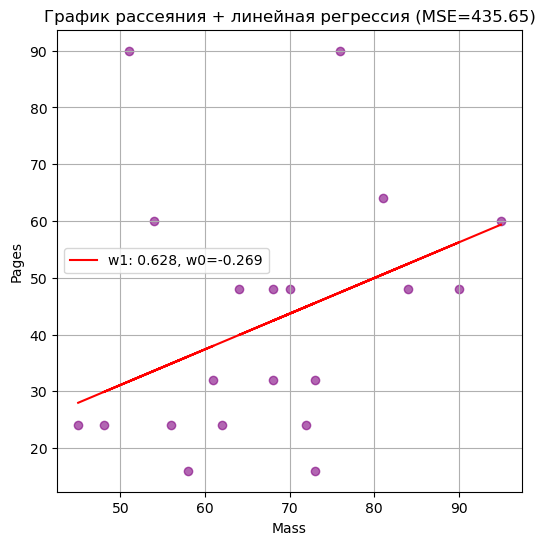

In [11]:
n = len(X)

# Эти штуки выведены из СЛАУ AX = b, получившейся в результате приравнивания к 0 градиентов функции МНК
w0_lin = ((np.sum(X)*np.sum(Y*X) / np.sum(X**2)) - np.sum(Y)) / (np.sum(X) ** 2 / np.sum(X**2) + n)
w1_lin = np.sum(Y*X) / np.sum(X**2) - (np.sum(X) / np.sum(X**2)) * w0_lin

Y_hat = w1_lin*X + w0_lin
MSE = np.sum((Y - Y_hat) **2) / n

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='purple', alpha=0.6)
plt.title(f'График рассеяния + линейная регрессия (MSE={MSE:.2f})')
plt.xlabel('Mass')
plt.ylabel('Pages')
plt.grid()
plt.plot(X, w1_lin*X + w0_lin, color='red', linestyle='-', label=f'w1: {w1_lin:.3f}, w0={w0_lin:.3f}')
plt.legend()
plt.show()


### Квадратичная

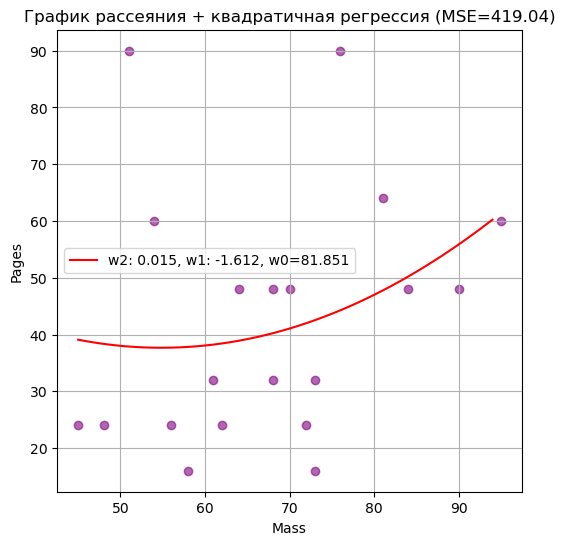

In [12]:
n = len(X)

# А вот тут уже ручками сложно вывести...
A = np.array([
    [np.sum(X**4), np.sum(X**3), np.sum(X**2)],
    [np.sum(X**3), np.sum(X**2), np.sum(X)],
    [np.sum(X**2), np.sum(X), n]
])

b = np.array([np.sum(Y*(X**2)), np.sum(Y*X), np.sum(Y)]).reshape(3, 1)
W = solve(A, b)

w2_quad = W[0][0]
w1_quad = W[1][0]
w0_quad = W[2][0]

Y_hat = w2_quad*(X**2) + w1_quad*X + w0_quad
MSE = np.sum((Y - Y_hat) **2) / n

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='purple', alpha=0.6)
plt.title(f'График рассеяния + квадратичная регрессия (MSE={MSE:.2f})')
plt.xlabel('Mass')
plt.ylabel('Pages')
plt.grid()
X_data = np.arange(np.min(X), np.max(X))
plt.plot(X_data, w2_quad*(X_data**2) + w1_quad * X_data + w0_quad, color='red', linestyle='-', label=f'w2: {w2_quad:.3f}, w1: {w1_quad:.3f}, w0={w0_quad:.3f}')
plt.legend()
plt.show()

### Гиперболическая

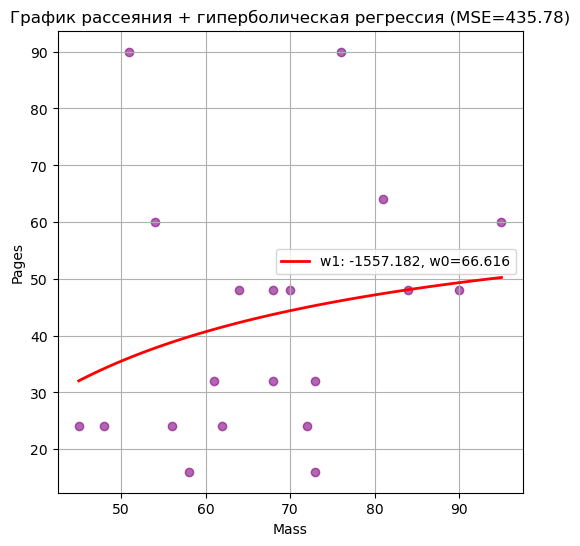

In [22]:
n = len(X)
Z = 1 / X

w1_hyp = (np.sum(Z * Y) - (np.sum(Z) * np.sum(Y)) / n) / (np.sum(Z ** 2) - (np.sum(Z) ** 2) / n)
w0_hyp = (np.sum(Y) - w1_hyp * np.sum(Z)) / n

Y_hat = w1_hyp / X + w0_hyp
MSE = np.mean((Y - Y_hat) ** 2)


plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='purple', alpha=0.6)
plt.title(f'График рассеяния + гиперболическая регрессия (MSE={MSE:.2f})')
plt.xlabel('Mass')
plt.ylabel('Pages')
plt.grid()
X_data = np.linspace(np.min(X), np.max(X), 100)
Y_data = w1_hyp / X_data + w0_hyp
plt.plot(X_data, Y_data, color='red', linewidth=2, linestyle='-', label=f'w1: {w1_hyp:.3f}, w0={w0_hyp:.3f}')
plt.legend()
plt.show()

### Показательная

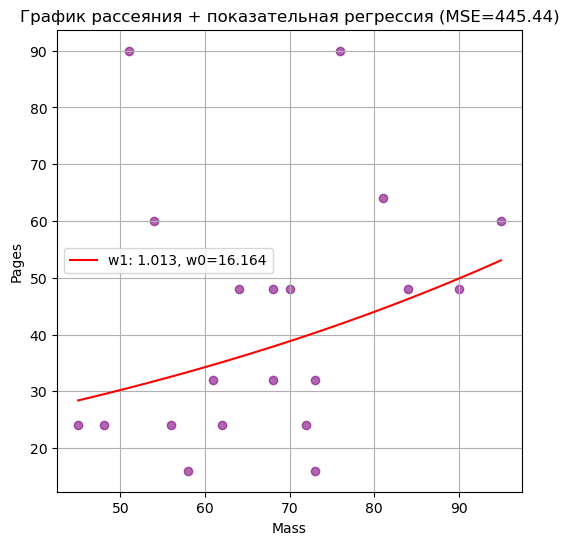

In [19]:
n = len(X)

log_Y = np.log(Y)
n = len(X)

w1_hat_log = (np.sum(X * log_Y) - (np.sum(X) * np.sum(log_Y)) / n) / (np.sum(X ** 2) - (np.sum(X) ** 2) / n)
w0_hat_log = np.mean(log_Y) - w1_hat_log * np.mean(X)

w1_exp = np.exp(w1_hat_log)
w0_exp = np.exp(w0_hat_log)

Y_hat = w1_exp ** X * w0_exp
MSE = np.mean((Y - Y_hat) ** 2)

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='purple', alpha=0.6)
plt.title(f'График рассеяния + показательная регрессия (MSE={MSE:.2f})')
plt.xlabel('Mass')
plt.ylabel('Pages')
plt.grid()
X_data = np.linspace(np.min(X), np.max(X), 100)
Y_data = w1_exp ** X_data * w0_exp
plt.plot(X_data, Y_data, color='red', linestyle='-', label=f'w1: {w1_exp:.3f}, w0={w0_exp:.3f}')
plt.legend()
plt.show()

### Выводы
Таким образом, лучшая модель - *квадратичная*, худшая - *показательная*

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

Из предыдущего пункта ясно, что лучшая модель - *квадратичная*, худшая - *показательная*

In [23]:
n = len(X)

Y_hat_exp = w1_exp**X * w0_exp
Y_hat_quad = w2_quad*(X**2) + w1_quad*X + w0_quad

Y_cap = np.mean(Y)

R_sq_quad = 1 - np.sum((Y-Y_hat_quad) ** 2)/np.sum((Y-Y_cap) ** 2)
R_sq_exp = 1 - np.sum((Y-Y_hat_exp) ** 2)/np.sum((Y-Y_cap) ** 2)

p1_quad, p2_quad = 2, n - 3
p1_exp, p2_exp = 1, n - 2

F_quad = (R_sq_quad / (1 - R_sq_quad)) * (p2_quad / p1_quad)
F_exp = (R_sq_exp / (1 - R_sq_exp)) * (p2_exp / p1_exp)

F_crit_quad = stats.f.ppf(0.95, p1_quad, p2_quad)
F_crit_exp = stats.f.ppf(0.95, p1_exp, p2_exp)

p_value_quad = 1 - stats.f.cdf(F_quad, p1_quad, p2_quad)
p_value_exp = 1 - stats.f.cdf(F_exp, p1_exp, p2_exp)

print(f'КВАДРАТИЧНАЯ МОДЕЛЬ {w2_quad:.3f}x^2 + {w1_quad:.3f}x + {w0_quad:.3f}: ')
print(f'R^2 = {R_sq_quad:.3f}\nF-статистика = {F_quad:.3f}\nF критическое = {F_crit_quad:.3f}\np-value = {p_value_quad:.3f}')
print(f'Модель {'значима' if F_quad > F_crit_quad else 'НЕ значима'} по критическому значению')
print(f'Модель {'значима' if p_value_quad < 0.05 else 'НЕ значима'} по p-значению\n')


print(f'ПОКАЗАТЕЛЬНАЯ МОДЕЛЬ {w1_exp:.3f}^x*{w0_exp:.3f}: ')
print(f'R^2 = {R_sq_exp:.3f}\nF-статистика = {F_exp:.3f}\nF критическое = {F_crit_exp:.3f}\np-value = {p_value_exp:.3f}')
print(f'Модель {'значима' if F_exp > F_crit_exp else 'НЕ значима'} по критическому значению')
print(f'Модель {'значима' if p_value_exp < 0.05 else 'НЕ значима'} по p-значению\n')

КВАДРАТИЧНАЯ МОДЕЛЬ 0.015x^2 + -1.612x + 81.851: 
R^2 = 0.088
F-статистика = 0.815
F критическое = 3.592
p-value = 0.459
Модель НЕ значима по критическому значению
Модель НЕ значима по p-значению

ПОКАЗАТЕЛЬНАЯ МОДЕЛЬ 1.013^x*16.164: 
R^2 = 0.030
F-статистика = 0.558
F критическое = 4.414
p-value = 0.465
Модель НЕ значима по критическому значению
Модель НЕ значима по p-значению



### Выводы
Таким образом, данные не коррелируют

## 5. Выводы
Сделать вывод по каждому пункту